In [1]:
# Predict the lung boxes
# Remove child data
# Convert the PIL image to grayscale in the dataloader

In [2]:
ENV = 'Kaggle' # VAST, Kaggle

In [3]:
# Ref:

# Blog post
# Part1: Mask-RCNN
# https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-2Wt-xBzUK

# Part 2: Faster-RCNN Beagle Detector
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-8k_OxBzUK

# Video by DigitalSreeni
# https://www.youtube.com/watch?v=NEl9RPyMgzY&t=28s

# TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Beagle Detector: Fine-tune Faster-RCNN
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-2VjexBzUI

In [4]:
# Install pycocotools

!pip install pycocotools

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373767 sha256=661d23217644e63b4a887cc4ce981ad10d1dedfd2ed7fb14f1e75cb8bb3a0f69
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [5]:
# See: https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-3RVOxBzUL

# For training process, we will use some helper functions from PyTorch Github Repo. 
# They are located in references/detection/ 
# We will use references/detection/engine.py, references/detection/utils.py and 
# references/detection/transforms.py.

!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Cloning into 'vision'...
remote: Enumerating objects: 321950, done.
remote: Counting objects: 100% (4972/4972), done.
remote: Compressing objects: 100% (539/539), done.
remote: Total 321950 (delta 4570), reused 4793 (delta 4424), pack-reused 316978
Receiving objects: 100% (321950/321950), 652.18 MiB | 35.71 MiB/s, done.
Resolving deltas: 100% (295944/295944), done.
/kaggle/working/vision
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branc

In [6]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
LICENSE      README.rst  hubconf.py  setup.cfg	test	     tox.ini
MANIFEST.in  docs	 references  setup.py	torchvision


In [7]:
# Change the working directory back to '/kaggle/working'

import os

root = '/kaggle/working'
os.chdir(root)

!pwd

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/kaggle/working


In [8]:
# Notes:

# 1- No need to resize images. This is done inside the model just like Yolv5.
#    I think the collator that's defined in the dataloader takes care of this.
# 2- bbox coords are automatically modified during augmentation. No need to do anything.

In [9]:
import pandas as pd
import numpy as np
import os

import cv2

import ast

import torch
import torchvision.transforms as T
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.utils.data
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.12.0
0.13.0


In [10]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [11]:
if ENV == 'VAST':
    
    root = '/root'
    base_path = '/root/'
    data_path = '/root/df_data_w_lung_boxes.csv'
    tbx11k_images_path = '/root/tbx11k-simplified/tbx11k-simplified/images/'
    pneu_comp_images_path = '/root/pneumonia-comp-proc-images/base_dir/pneu_comp/'
    covid_comp_images_path = '/root/covid-comp-proc-images/base_dir/covid_comp/'
    

if ENV == 'Kaggle':
    
    root = '/kaggle/working'
    base_path = '../input/'
    data_path = '../input/exp77-tb-add-lung-boxes-to-detection-folds/df_data_w_lung_boxes.csv'
    tbx11k_images_path = '../input/tbx11k-simplified/tbx11k-simplified/images/'
    pneu_comp_images_path = '../input/pneumonia-comp-proc-images/base_dir/pneu_comp/'
    covid_comp_images_path = '../input/covid-comp-proc-images/base_dir/covid_comp/'
    
    
print(ENV)

Kaggle


In [12]:
os.listdir('../input/')

['covid-comp-proc-images',
 'pneumonia-comp-proc-images',
 'exp77-tb-add-lung-boxes-to-detection-folds',
 'exp19-tb-prepare-the-folds',
 'vindr-comp-proc-images',
 'tbx11k-simplified']

In [13]:
## Notes

# df_data
# 1- Create a dataframe called df_data that contains unique file names.
# 2- Create a unique image_id for each row in this dataframe.
# 3- Set iscrowd to be 0 for all rows in this dataframe.
# 4- This dataframe must contain the path to each image.
# 5- There should only be target 1 images in this dataframe.

# df_boxes
# 5- Create a dataframe called df_boxes that only contains rows that have bboxes.
# 6- Each bbox must be on a seperate row.
# 7- Each bbox must be a list with this format: [xmin, ymin, xmax, ymax]

## Config

In [14]:
CLASS_LIST = CLASS_NAMES = ['background','opacity', 'normal', 'lungs']

CHOSEN_FOLD = 0

THRESHOLD = 0.5

# Number of normal images to use during training
#SAMPLE_SIZE = 7000

NUM_EPOCHS = 8

TRAIN_BATCH_SIZE = 5
VAL_BATCH_SIZE = 1


NUM_CORES = os.cpu_count()
NUM_CORES

2

## Define the device

In [15]:
# For GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

cuda:0
Num GPUs: 1
GPU Type: Tesla P100-PCIE-16GB


## Load the train data
Each bbbox is on a separate row.

In [16]:
path = data_path

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head(2)

(60109, 9)


,fname,image_height,image_width,bbox,target,data_source,label,path,fold
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0


In [17]:
df_data['data_source'].value_counts()

pneu_comp     33265
covid_comp    12198
vindr_comp     6665
tbx11k         5010
vindr_pcxr     2971
Name: data_source, dtype: int64

In [18]:
df = df_data[df_data['data_source'] == 'covid_comp']

print('Total: ',df['fname'].nunique())

df1 = df[df['target'] == 1]
print('Target 1: ',df1['fname'].nunique())

df0 = df[df['target'] == 0]
print('Target 0: ', df0['fname'].nunique())

Total:  4587
Target 1:  2851
Target 0:  1736


## Remove vindr_pcxr data

In [19]:
df_data = df_data[df_data['data_source'] != 'vindr_pcxr']

df_data = df_data.reset_index(drop=True)

df_data['data_source'].value_counts()

pneu_comp     33265
covid_comp    12198
vindr_comp     6665
tbx11k         5010
Name: data_source, dtype: int64

In [20]:
df1 = df_data[df_data['target'] == 1]
print('Target 1: ',df1['fname'].nunique())

df0 = df_data[df_data['target'] == 0]
print('Target 0: ', df0['fname'].nunique())

Target 1:  10983
Target 0:  13516


In [21]:
df0 = df_data[df_data['target'] == 0]

df0['label'].value_counts()

Normal                    8850
negative_for_pneumonia    1736
healthy                   1500
No finding                1430
Name: label, dtype: int64

## Adjust the target

In [22]:
# Change the target from 0 to 2

def change_target(x):
    
    if x == 0:
        return 2
    elif x == 1:
        return 1
    elif x == 3:
        return 3
    
df_data['target'] = df_data['target'].apply(change_target)

df_data.head()

,fname,image_height,image_width,bbox,target,data_source,label,path,fold
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0
2,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0
3,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 695, 'ymin': 575, 'width': 162, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0
4,00aecb01-a116-45a2-956c-08d2fa55433f.png,1024,1024,"{'xmin': 288, 'ymin': 322, 'width': 94, 'heigh...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,1.0


In [23]:
df_data['target'].value_counts()

3    24499
1    19123
2    13516
Name: target, dtype: int64

## Process the data

In [24]:
# Create a column with the bbox in the following list format:
# [xmin, ymin, xmax, ymax]

def format_bbox_coords(row):
    
    bbox_coords = row['bbox']
    image_h = row['image_height']
    image_w = row['image_width']
    
    if bbox_coords != 'none':
    
        bbox_coords = ast.literal_eval(bbox_coords)
        xmin = bbox_coords['xmin']
        ymin = bbox_coords['ymin']
        width = bbox_coords['width']
        height = bbox_coords['height']

        xmax = xmin + width
        ymax = ymin + height

        coords_list = [xmin, ymin, xmax, ymax]
        
        return coords_list
    
    else:
        
        coords_list = [0, 0, image_w, image_h]
        
        return coords_list
    
    

df_data['boxes'] = df_data.apply(format_bbox_coords, axis=1)

df_data.head(2)

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]"
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[562, 152, 818, 605]"


## Sample class 0

In [25]:
# Separate the classes
# Class 2 are the normal images
df1 = df_data[df_data['target'] == 1]
df0 = df_data[df_data['target'] == 2]
df3 = df_data[df_data['target'] == 3]



# Take a sample of the normal images
#df_sample = df2.sample(n=SAMPLE_SIZE, random_state=101)

#########################

# Choose the number of traget 2 (i.e. target 0) images we want from each data source

num_samples_dict = {
    'pneu_comp': 2700,
    'covid_comp': 1400,
    'vindr_comp': 1100,
    'tbx11k': 1100
    #'vindr_pcxr': 700
}

#########################

# get the list of data sources
data_source_list = list(num_samples_dict.keys())

for i, data_source in enumerate(data_source_list):
    
    # Get the sample size that we chose for the data source
    sample_size = num_samples_dict[data_source]
    
    # Filter
    df = df0[df0['data_source'] == data_source]
    
    # Take a sample
    df_sample = df.sample(n=sample_size)
    
    if i == 0:
        df_fin = df_sample
    else:
        df_fin = pd.concat([df_fin, df_sample], axis=0)



# adjust df3 - lungs
# We want to exclude images that were not part of the sample
df3 = df_data[df_data['target'] == 3]
list1 = list(df1['fname'])
list2 = list(df_fin['fname'])  ### The error was here

# Join the lists
fin_list = list1 + list2

# Create df3
df3 = df3[df3['fname'].isin(fin_list)]

# Concat the dataframes
df_data = pd.concat([df1, df_fin, df3], axis=0)

# Reset the index
df_data = df_data.reset_index(drop=True)

df_data['target'].value_counts()

1    19123
3    17283
2     6300
Name: target, dtype: int64

In [26]:
2700+1400+1100 +1100

6300

In [27]:
10983 + 6300

17283

In [28]:
# There should be one target 3 (lung bbox) image
# for every target 0 and target 1 image in the dataset.

df3 = df_data[df_data['target'] == 3]
df = df_data[df_data['target'] != 3]

print(len(df3))
print(df['fname'].nunique())

17283
17283


## Create df_boxes

In [29]:
df_boxes = df_data.copy()

# Create an iscrowd column
df_boxes['iscrowd'] = 0

df_boxes.head()

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes,iscrowd
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]",0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[562, 152, 818, 605]",0
2,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[323, 577, 483, 681]",0
3,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 695, 'ymin': 575, 'width': 162, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[695, 575, 857, 712]",0
4,00aecb01-a116-45a2-956c-08d2fa55433f.png,1024,1024,"{'xmin': 288, 'ymin': 322, 'width': 94, 'heigh...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,1.0,"[288, 322, 382, 457]",0


## Create df_data with unique image_ids

In [30]:
# Remove the duplicate fnames

df_data = df_boxes.drop_duplicates(subset='fname')

df_data = df_data.reset_index(drop=True)

print(df_data.shape)

df_data.head(2)

(17283, 11)


,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes,iscrowd
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]",0
1,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[323, 577, 483, 681]",0


In [31]:
# Create an image_id column

df_data['image_id'] = df_data.index

df_data.head(2)

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes,iscrowd,image_id
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]",0,0
1,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[323, 577, 483, 681]",0,1


## Helper functions

In [32]:
def display_images(df):
    
    """
    Display jpg images in a grid.
    """
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 5
    cols = 6

    for i in range(rows*cols):

        path = df.loc[i, 'path']
        label = df.loc[i, 'label']
        
        image = plt.imread(path)

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [33]:
def display_images_from_batch(images):
    
    """
    Display torch tensor images from the dataloader.
    """
    
    #images = data['images']
    #targets = data['targets']
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 1
    cols = 3

    for i in range(rows*cols):

        image = images[i]
        #label = targets[i]

        # convert from (C, H, W) to (H, W, C) format
        image = image.permute((1, 2, 0))

        # select the first channel only
        image = image[:, :, 0]

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        #plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [34]:
def draw_bbox_on_image(image, coords_list):
    
    """
    Input:
    image: type numpy array
    coords_list: type list with format: [xmin, ymin, xmax, ymax]
    
    Output:
    image: The bbox is drawn on it.
    
    """

    xmin = int(coords_list[0])
    ymin = int(coords_list[1])
    xmax = int(coords_list[2])
    ymax = int(coords_list[3])

     # Draw the bbox on the image
    start_point = (xmin, ymin) 
    end_point = (xmax, ymax) 
    bbox_color = (255, 255, 0)  # yellow
    bbox_thickness = 2

    image = cv2.rectangle(image, start_point, end_point, 
                          bbox_color, bbox_thickness)
    
    return image

In [35]:
def draw_mask_on_image(image, bool_mask):
    
    # Define a function that outputs a mask with a random colour
    def get_coloured_mask(mask):
    
        """
        Source: https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-3RVOxBzUL

        random_colour_masks

        """

        colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
        r = np.zeros_like(mask).astype(np.uint8)
        g = np.zeros_like(mask).astype(np.uint8)
        b = np.zeros_like(mask).astype(np.uint8)

        r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]

        coloured_mask = np.stack([r, g, b], axis=2)

        return coloured_mask


    rgb_mask = get_coloured_mask(bool_mask)
    image = cv2.addWeighted(image, 1, rgb_mask, 0.5, 0)
    
    return image

In [36]:
# Cutout augmentation

def create_multi_cutout_image(input_image, num_cutouts, IMAGE_HEIGHT, IMAGE_WIDTH):
    
    """
    The objective is to insert a black area into the image.
    This forces the model to look at different parts of the image
    and not just focus on certain features.
    The image target does not get modified.
    
    input_image: type np array
    
    Outputs:
    - The input_image with black squares cropped area inserted.

    """

    
    # Resize the image
    # ..................
    
    # resize input_image
    #image1 = cv2.resize(input_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image1 = input_image.copy()
    
    
    
    # Create the cutout image
    # .......................
    
    # create a random height and width
    percent_size_h = np.random.uniform(low=0.02, high=0.08)
    #percent_size_w = np.random.uniform(low=0.01, high=0.08)
    percent_size_w = percent_size_h
    
    # set the crop height and width
    h = round(percent_size_h * IMAGE_HEIGHT)
    w = round(percent_size_w * IMAGE_WIDTH)
    
    #h = 20
    #w = 20
    
    
    # make sure the crop doesn't extend out of the image
    max_y = IMAGE_HEIGHT - h
    max_x = IMAGE_WIDTH - w
    
    
    for i in range(0, num_cutouts):
    
        # get coordinates
        # Remember that for images the origin (0,0) is in the top left corner and
        # not in the bottom left corner.

        # get a random x-coord
        y = np.random.randint(0, max_y)
        # get a random y-coord
        x = np.random.randint(0, max_x)


        # insert the crop into image1 at the x and y coordinates
        image1[y:y+h, x:x+w] = 0


     
    return image1

In [37]:
# How to pad an image to a sqaure
# We pad the right and the bottom so that if there are bbox coords
# then they won't be affected by the padding. That's because the origin for
# the coords is in the top left corner.

def pad_image_to_square(image):
    
    """
    Pads an image to a square. 
    Accepts bot grayscale and multi channel images.
    """
    
    # Get the image shape
    shape_tuple = image.shape
    
    height = image.shape[0]
    width = image.shape[1]
    
    
    # Function to pad each channel of an image to a square
    # Also pads a grayscale image to a square.
    def pad_image_channel(image_channel, height, width):

        pad_amt = abs(height - width)

        if height == width:
            pad_channel = image_channel

        elif height > width: # pad right
            top = 0
            bottom = 0
            left = 0
            right = pad_amt

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        else: # if width > height then pad bottom

            top = 0
            bottom = pad_amt
            left = 0
            right = 0

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        return pad_channel

    
    # If image is grayscale i.e. shape (height, width)
    if len(shape_tuple) == 2:
        
        # pad the image
        padded_image =  pad_image_channel(image, height, width)
    
    # If the image is not grayscale i.e. shape (height, width, num_channels)
    elif len(shape_tuple) == 3:
        
        # get the number of channels
        num_channels = image.shape[2]
        
        for j in range(0, num_channels):
            
            # select the channel
            image_channel = image[:,:,j]
            
            # pad the channels
            padded_channel =  pad_image_channel(image_channel, height, width)
            
            if j == 0:
                padded_image = padded_channel
                
            else:
                # Stack the channels along the channel axis
                padded_image = np.dstack((padded_image, padded_channel))
                
                
    return padded_image

## Display images

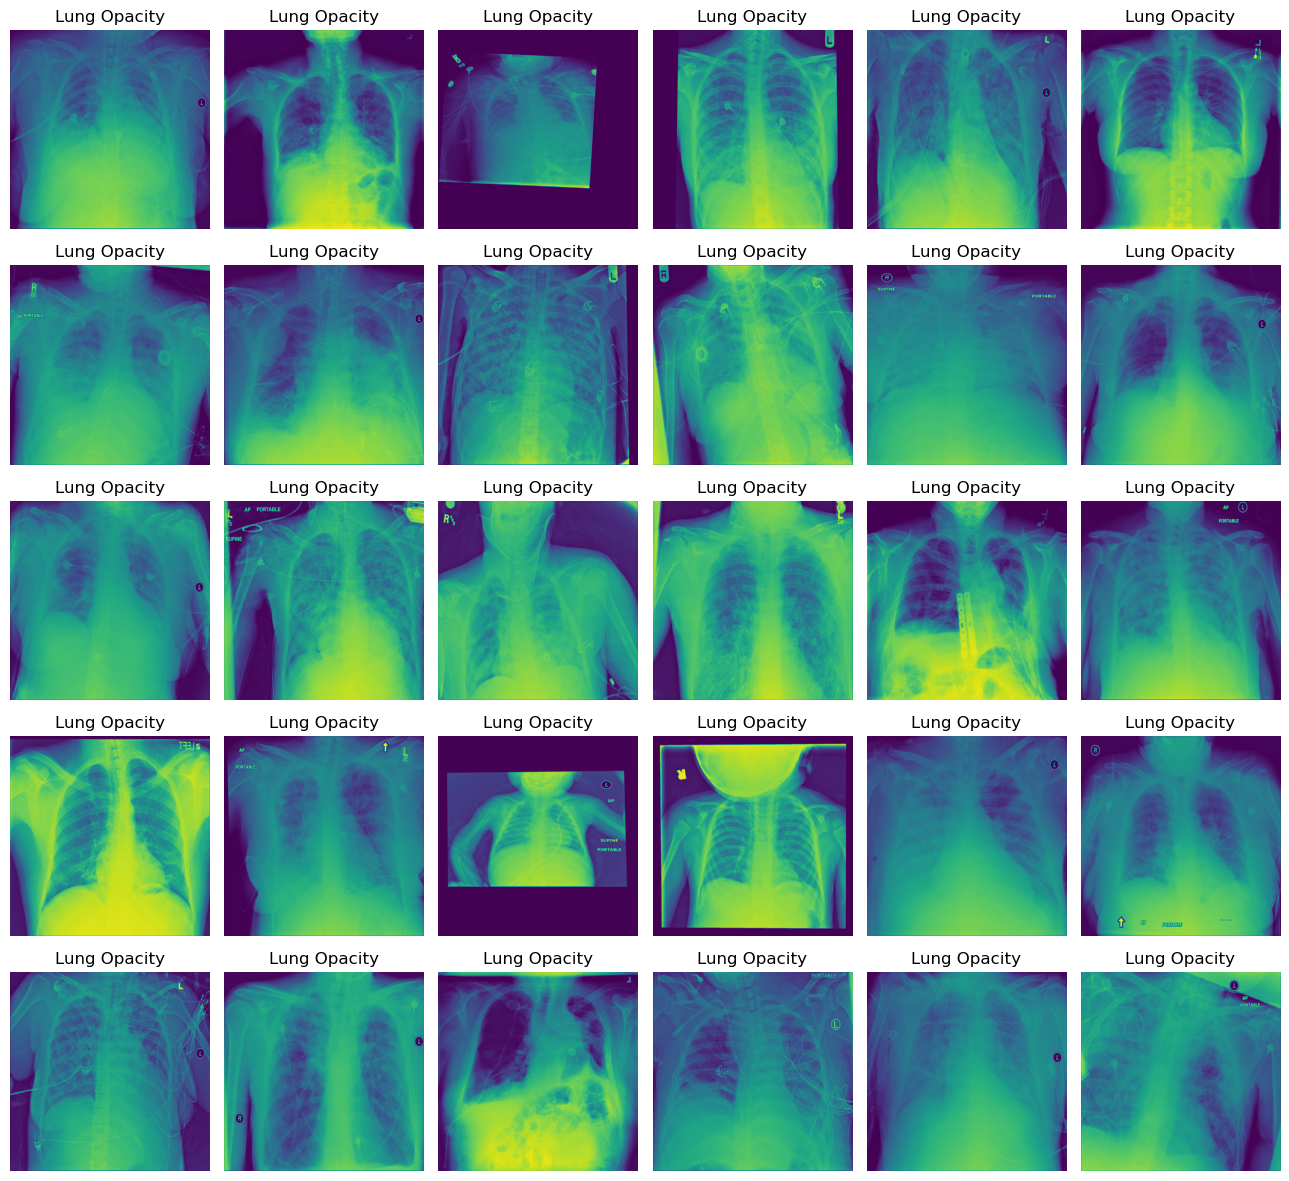

In [38]:
display_images(df_data)

## Set up augmentation

- NOTE: Rotations don't adjust the bboxes correctly. That's why don't use them.

In [39]:
df_boxes.head()

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes,iscrowd
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]",0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[562, 152, 818, 605]",0
2,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[323, 577, 483, 681]",0
3,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 695, 'ymin': 575, 'width': 162, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"[695, 575, 857, 712]",0
4,00aecb01-a116-45a2-956c-08d2fa55433f.png,1024,1024,"{'xmin': 288, 'ymin': 322, 'width': 94, 'heigh...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,1.0,"[288, 322, 382, 457]",0


In [40]:
# Choose the fname

df = df_boxes[df_boxes['fname'] == '00436515-870c-4b36-a041-de91049b9ab4.png']
#df = df.drop_duplicates()
df = df.reset_index(drop=True)

df

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,boxes,iscrowd
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[264, 152, 477, 531]",0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[562, 152, 818, 605]",0
2,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 167, 'ymin': 89, 'width': 667, 'heigh...",3,pneu_comp,lungs,../input/pneumonia-comp-proc-images/base_dir/p...,3.0,"[167, 89, 834, 654]",0


In [41]:
boxes_list = list(df['boxes'])

target_list = list(df['target'])

print(target_list)
print(boxes_list)

[1, 1, 3]
[[264, 152, 477, 531], [562, 152, 818, 605], [167, 89, 834, 654]]


(1024, 1024, 3)


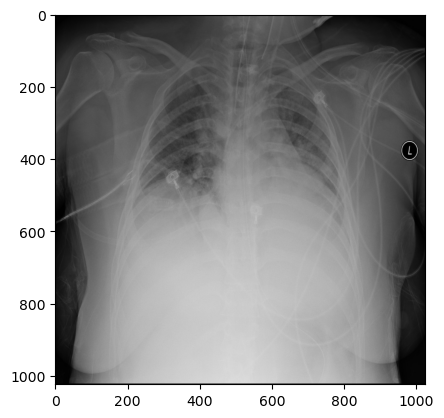

In [42]:
path = df.loc[0, 'path']

image1 = Image.open(path).convert("RGB")

image = np.array(image1)

"""
for coords_list in boxes_list:
    
    image = draw_bbox_on_image(image, coords_list)
"""


print(image.shape)

plt.imshow(image)

In [43]:
# Tutorial: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

import albumentations as A
import cv2

# Notes

# 1- format options: pascal_voc, albumentations, coco, yolo
# pascal_voc format is: [xmin, ymin, xmax, ymax]

# 2- min_visibility: After augmentation if the size of the bbox
# is less than say 10% of the original bbox then that bboxes label
# will be excluded from the list of transformed_class_labels. 

# 3- The input image must be a numpy array.


transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(height=768, width=768, p=1.0),
    #A.RandomCrop(width=450, height=450),
    #A.HorizontalFlip(p=1.0),
    #A.Rotate(limit=10, p=1.0),
    #A.Rotate (limit=180, p=0.5), # Test this
    A.VerticalFlip(p=1.0),
    
    #A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.1, 
                            label_fields=['class_labels']))


transformed = transform(image=image, bboxes=boxes_list, class_labels=target_list)

transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']

print(transformed_bboxes)
print(transformed_class_labels)

[(102.93823915900131, 345.9290085679314, 317.8975032851511, 702.1982864137087), (403.6793692509856, 276.36719706242354, 662.0341655716163, 702.1982864137087), (5.045992115637319, 230.30599755201956, 678.1813403416556, 761.4198286413709)]
[1, 1, 3]


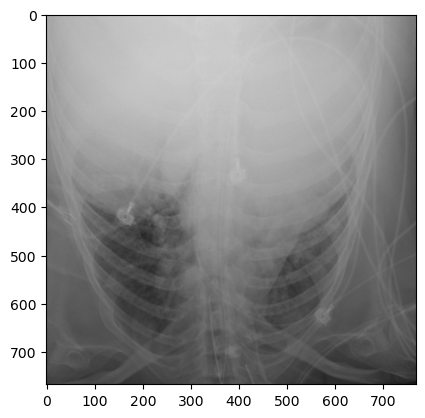

In [44]:
plt.imshow(transformed_image)

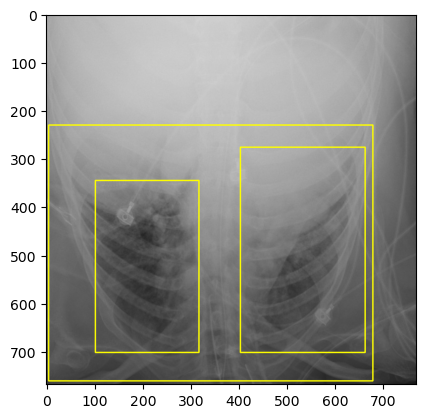

In [45]:
for coords_list in transformed_bboxes:
    
    transformed_image = draw_bbox_on_image(transformed_image, coords_list)
    
plt.imshow(transformed_image)

## Set up albumentations transforms

In [46]:
import albumentations as A
import cv2

# 1- A.RandomSizedBBoxSafeCrop won't crop normal images because they are covered by
# one big bbox.
# 2- rotations don't adjust the bboxes correctly.
# 3- Always do the  A.RandomSizedBBoxSafeCrop first.

albu_transforms = A.Compose([
    A.RandomSizedBBoxSafeCrop(height=768, width=768, p=0.4), # makes sure the crop has the bboxes
    #A.ImageCompression(quality_lower=99, p=0.3), # if the user uses RGB images
    #A.RandomScale(scale_limit=0.1, p=0.4), # if the user uses resized images
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.Rotate (limit=180, p=0.5), # max 180 degree rotation. ### Test this seperately
    A.Sharpen(p=0.3),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Blur(p=0.3),
    
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.1, 
                            label_fields=['class_labels']))

In [47]:
i = 0

path = df.loc[i, 'path']

image1 = Image.open(path).convert("RGB")

image = np.array(image1)

transformed = albu_transforms(image=image, bboxes=boxes_list, class_labels=target_list)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']

print(transformed_bboxes)
print(transformed_class_labels)

[(461.4811529933481, 171.9576399394856, 642.8381374722838, 612.3086232980334), (171.13968957871393, 85.9788199697428, 389.1086474501108, 612.3086232980334), (157.51662971175165, 29.046898638426654, 725.4279379157429, 685.5068078668685)]
[1, 1, 3]


In [48]:
# Convert the list of tuples to a list of lists

def convert_to_list_of_lists(transformed_bboxes):

    fin_list = []

    for tuple_list in transformed_bboxes:

        my_list = []

        for item in tuple_list:
            my_list.append(item)

        fin_list.append(my_list)
        
    return fin_list  

output_list = convert_to_list_of_lists(transformed_bboxes)
    
output_list

[[461.4811529933481, 171.9576399394856, 642.8381374722838, 612.3086232980334],
 [171.13968957871393, 85.9788199697428, 389.1086474501108, 612.3086232980334],
 [157.51662971175165,
  29.046898638426654,
  725.4279379157429,
  685.5068078668685]]

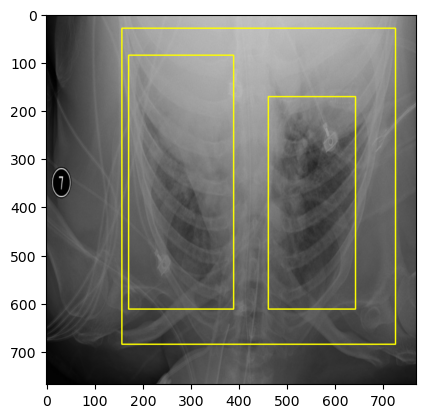

In [49]:
for coords_list in transformed_bboxes:
    
    transformed_image = draw_bbox_on_image(transformed_image, coords_list)
    
plt.imshow(transformed_image)

In [50]:
256*3

768

## Create the folds

In [51]:
# Use the train and val sets that were defined by the dataset creators

fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print('Train')
print(len(df_train))
print(df_train['target'].value_counts())
print('')
print('Val')
print(len(df_val))
print(df_val['target'].value_counts())

Train
13828
1    8782
2    5046
Name: target, dtype: int64

Val
3455
1    2201
2    1254
Name: target, dtype: int64


## Create the dataloader

In [52]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageOps


class CompDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, df_all_boxes, transforms=None, albu_transforms=None):
        self.df = df
        self.df_all_boxes = df_all_boxes
        self.transforms = transforms
        self.albu_transforms = albu_transforms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_path = self.df.loc[idx, 'path']
        fname = self.df.loc[idx, 'fname']
        image_id = self.df.loc[idx, 'image_id']
        
        
        # Load the image
        # The 'L' mode stands for luminance, and it represents the image in grayscale
        #img = Image.open(img_path).convert("RGB")
        img = Image.open(img_path).convert("L")
        
        
        
        # Pad the image to a square
        # The image gets padded on the right and
        # on the bottom so that the bbox coords are not
        # affected by the padding.
        # --------------------------
        
        # Convert from PIL to numpy
        img = np.array(img)
        
        # Pad to square
        img = pad_image_to_square(img)
        
        # Convert back to a PIL image
        img = Image.fromarray(np.uint8(img))
        
        # Convert to numpy so we can add cutouts and use albumentations
        img = np.array(img)

        # There's a 50% chance of cutout being applied because
        # the random number can be either 0 or 1.
        num = np.random.randint(0,2)

        if num == 1:
            
            if self.transforms is not None:

                # Convert to numpy
                #img = np.array(img)

                height = img.shape[0]
                width = img.shape[1]
                num_cutouts = 30

                # Add the cutouts
                img = create_multi_cutout_image(img, num_cutouts, height, width)

                # Convert back to a PIL image
                #img = Image.fromarray(np.uint8(img))
        
        
        # Get a list of bboxes. This is a list of lists. [[xmin, ymin, xmax, ymax], [], ...]
        df_image_boxes = self.df_all_boxes[self.df_all_boxes['fname'] == fname]
        boxes = list(df_image_boxes['boxes'])
        
        # Get the labels
        labels = list(df_image_boxes['target'])
        
        # Get iscrowd
        iscrowd = list(df_image_boxes['iscrowd'])
        
        
        if self.albu_transforms is not None:
            
            # Apply the alubumentations transformations
            transformed = self.albu_transforms(image=img, bboxes=boxes, class_labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']

            # Convert the list of tuples to a list of lists
            boxes = convert_to_list_of_lists(boxes)
            
        
        # Convert back to a PIL image
        img = Image.fromarray(np.uint8(img))
        
        

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        #masks = torch.as_tensor([], dtype=torch.uint8)

        image_id = torch.tensor([image_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

## Test the dataloader

Here we will make sure that we haven't made any mistakes when coding the dataloader. It's always good to visualize the images that come out of the dataloader to make sure everything is okay. If we don't do this we could get poor performance during training and not know what's causing it.

In [53]:
# Intialize the fold dataframes
fold = 0

df_train = df_data[df_data['fold'] != 0]
df_val = df_data[df_data['fold'] == 0]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)

(13828, 12)
(3455, 12)


In [54]:
from engine import train_one_epoch, evaluate
import utils
import transforms as Tr


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(Tr.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        #transforms.append(Tr.RandomHorizontalFlip(0.5))
        pass
    return Tr.Compose(transforms)



# use our dataset and defined transformations
train_dataset = CompDataset(df_train, df_boxes, get_transform(train=True))
val_dataset = CompDataset(df_val, df_boxes, get_transform(train=False))


# define training and validation data loadåers
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


print(len(train_dataloader))
print(len(val_dataloader))

2766
691


In [55]:
# Get one train batch

images, targets = next(iter(train_dataloader))

print(len(images))
print(len(targets))

5
5


In [56]:
images[0].shape

torch.Size([1, 1024, 1024])

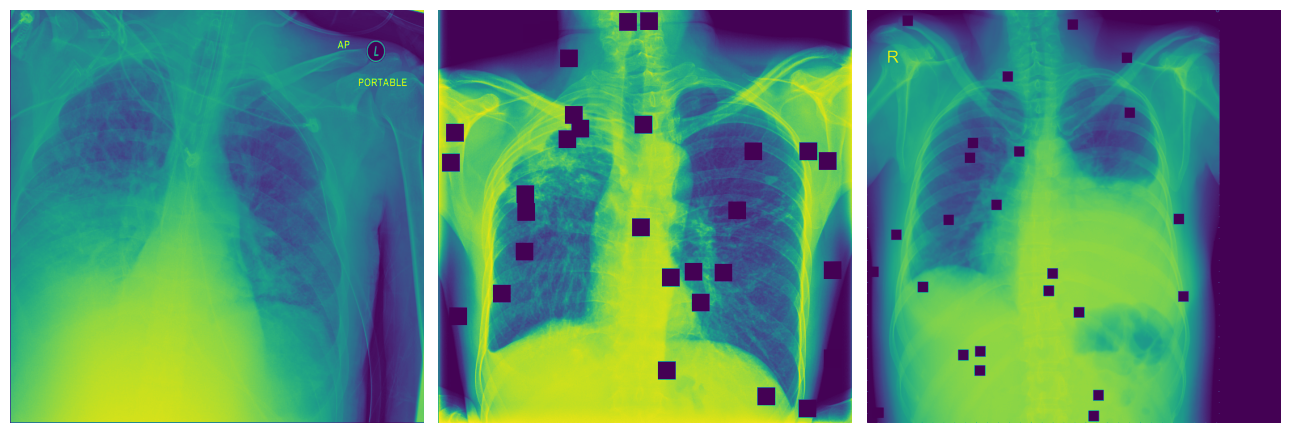

In [57]:
display_images_from_batch(images)

In [58]:
targets[4]

{'boxes': tensor([[ 363.1990, 1496.2418,  970.3485, 2088.8489],
         [1857.4413, 1445.3431, 2835.4246, 2219.7314],
         [ 192.0000,  154.0000, 2778.0000, 2484.0000]]),
 'labels': tensor([1, 1, 3]),
 'image_id': tensor([8798]),
 'area': tensor([ 359801.0938,  757338.8125, 6025380.0000]),
 'iscrowd': tensor([0, 0, 0], dtype=torch.uint8)}

In [59]:
# Get one val batch

images, targets = next(iter(val_dataloader))

print(len(images))
print(len(targets))

5
5


In [60]:
targets[0]

{'boxes': tensor([[323., 577., 483., 681.],
         [695., 575., 857., 712.],
         [254., 214., 895., 759.]]),
 'labels': tensor([1, 1, 3]),
 'image_id': tensor([1]),
 'area': tensor([ 16640.,  22194., 349345.]),
 'iscrowd': tensor([0, 0, 0], dtype=torch.uint8)}

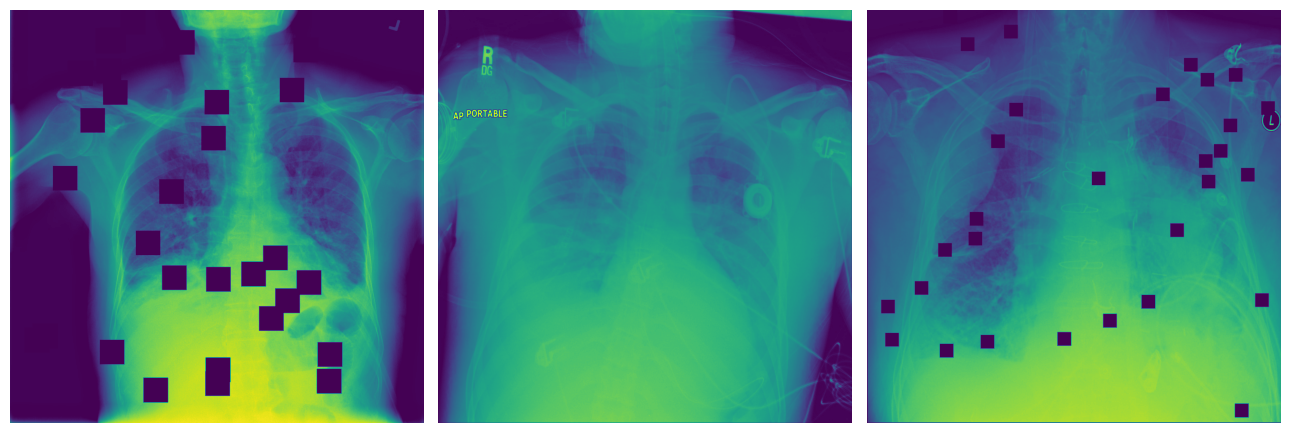

In [61]:
display_images_from_batch(images)

## Define the model

In [62]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    
    # load an instance segmentation model pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    """
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
                                                       
    """

    return model

In [63]:
num_classes = len(CLASS_LIST)

model = build_model(num_classes)

#print(model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## Test the model

Ref: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#testing-forward-method-optional

In [64]:
# Get one train batch

images, targets = next(iter(train_dataloader))

print(len(images))
print(len(targets))

5
5


In [65]:
# For training

targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections

output

{'loss_classifier': tensor(1.4371, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.2214, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1952, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0359, grad_fn=<DivBackward0>)}

In [66]:
# For inference

model.eval()

# Create dummy input
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]

# Make a prediction
predictions = model(x)

# peredictions is a list of dicts [{}, {}]
len(predictions)

2

In [67]:
#predictions

## Training

In [68]:
# Create dataloaders

train_dataset = CompDataset(df_train, df_boxes, get_transform(train=True))
val_dataset = CompDataset(df_val, df_boxes, get_transform(train=False))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_CORES,
    collate_fn=utils.collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_CORES,
    collate_fn=utils.collate_fn)


print(len(train_dataloader))
print(len(val_dataloader))

2766
3455


In [69]:
# Remember that 'background' is class 0
num_classes = len(CLASS_LIST)

# get the model using our helper function
model = build_model(num_classes)

# move model to the device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [70]:
# Training loop

for epoch in range(0, NUM_EPOCHS):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    

Epoch: [0]  [   0/2766]  eta: 5:29:07  lr: 0.000010  loss: 1.6828 (1.6828)  loss_classifier: 1.2854 (1.2854)  loss_box_reg: 0.2052 (0.2052)  loss_objectness: 0.1673 (0.1673)  loss_rpn_box_reg: 0.0248 (0.0248)  time: 7.1393  data: 0.9859  max mem: 3274
Epoch: [0]  [ 100/2766]  eta: 0:38:19  lr: 0.000509  loss: 0.4165 (0.6182)  loss_classifier: 0.1531 (0.3404)  loss_box_reg: 0.1994 (0.2003)  loss_objectness: 0.0282 (0.0572)  loss_rpn_box_reg: 0.0166 (0.0203)  time: 0.8107  data: 0.0621  max mem: 3737
Epoch: [0]  [ 200/2766]  eta: 0:35:39  lr: 0.001009  loss: 0.3486 (0.4908)  loss_classifier: 0.1348 (0.2384)  loss_box_reg: 0.1639 (0.1902)  loss_objectness: 0.0198 (0.0450)  loss_rpn_box_reg: 0.0129 (0.0173)  time: 0.8282  data: 0.0704  max mem: 3737
Epoch: [0]  [ 300/2766]  eta: 0:33:46  lr: 0.001508  loss: 0.2876 (0.4276)  loss_classifier: 0.1123 (0.1978)  loss_box_reg: 0.1568 (0.1760)  loss_objectness: 0.0154 (0.0383)  loss_rpn_box_reg: 0.0117 (0.0155)  time: 0.8085  data: 0.0468  max me

## Save the model

In [71]:
torch.save(model, 'model.pt')

In [72]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  coco_eval.py   engine.py  transforms.py  vision
__pycache__	    coco_utils.py  model.pt   utils.py


In [73]:
# Create a requirements.txt file
# This is a list of all packages and their versions that were 
# used to create this solution.

!pip freeze > requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [74]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  coco_eval.py   engine.py  requirements.txt	utils.py
__pycache__	    coco_utils.py  model.pt   transforms.py	vision
